# Quora Question Pairs

### Metrice(s):
- Log Loss.
- Binary Confusion Matrix.

## 2.3 Train and Test Construction

We build train and test by randomly splitting in the ration of <font color='red'><b>70:30</b></font> or <font color='red'><b>80:20</b></font> whatever we choose as we have sufficient points to work with.
**NOTE:** Time-based splittin would be efficient, but since we don't have the timestamp of the questions, we can't use it.

# 3. Exploratory Data Analysis

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from subprocess import check_output # New to the course
import plotly.offline as py # New to the Course
py.init_notebook_mode(connected=True) # New to the Course
import plotly.graph_objs as go # New to the Course
import plotly.tools as tls # New to the Course
import os
import gc # New to the course

import re
from nltk.corpus import stopwords
# import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%precision 2
plt.style.use('ggplot')
sns.set_style('white')

In [5]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/quora-question-pairs/sample_submission.csv
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/train.csv


# 3.1 Reading data and Basic Stats

In [9]:
df = pd.read_csv('/kaggle/input/quora-question-pairs/train.csv')

print('Number of data points:', df.shape[0])

Number of data points: 404290


In [12]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
398179,398179,531386,531387,What are some bad qualities that are good-to-h...,What are some habits that improved the quality...,0
222889,222889,88909,18157,How can I hack someone's whatsapp account and ...,How do I hack or spy on someone's WhatsApp con...,1
18854,18854,35683,35684,Who will win the 2017 Champions League?,Who is going to win the Champions League 2016/17?,1
291684,291684,413146,413147,Why exactly was JFK assassinated?,What was the main reason why JFK got assassina...,1
354964,354964,484146,484147,What is a good website to check statements mad...,How big is the illegal file sharing market?,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


#### Observation:
- we can see from `info`, that `question1` and `question2` columns have some null values, but it's not that much.

We are given a minimal number of data fields here, consisting of:
- id: Looks like a simple rowID.
- qid{1, 2}: The unique ID of each question in the pair.
- question{1, 2}: The actual textual contents of the questions.
- is_duplicate: The label that we are trying to predict - whether the two questions are duplicated of each other.

## 3.2.1 Distribution of data points among output classes
Number of duplicate(similar) and non-duplicate(non-similar) questions.

In [66]:
def show_annotation(colName):
    # Add Anootations
    n_points = df.shape[0]
    duplicate_count = df[colName].value_counts()
    locs, labels = plt.xticks() # Get the current tick locations and labels

    # Loop for through each pair of locations and labels.
    for loc, label in zip(locs, labels):
        count = duplicate_count[int(label.get_text())]
        text  = '{:.2f}%'.format(100*count/n_points)
        plt.text(loc, count-50, text, ha='center', color='darkblue')  

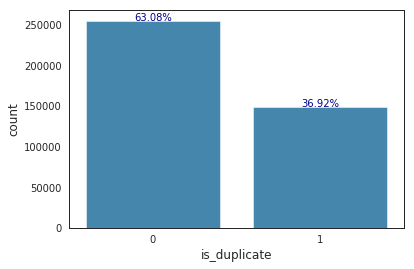

In [67]:
base_color = sns.color_palette()[1]
sns.countplot(data=df, x='is_duplicate', color=base_color);

show_annotation('is_duplicate')

In [27]:
def bg(value, color='blue'):
    return colored(value, color, attrs=['reverse', 'blink'])

In [24]:
totalRows = df.shape[0]
print('~> Total number of question pairs for training:\t', colored(totalRows, 'blue', attrs=['reverse', 'blink']))

~> Total number of question pairs for training:	 404290


In [42]:
numSimilarQuestions    = len(df[df['is_duplicate']==1])
numNotSimilarQuestions = len(df[df['is_duplicate']==0])

print('~> Percentage of Similar Questions (is_duplicate = 1): {:.2f}%'.format(((numSimilarQuestions/totalRows)*100)))
print('~> Percentage of Non-Similar Questions (is_duplicate = 0): {:.2f}%'.format(((numNotSimilarQuestions/totalRows)*100)))

~> Percentage of Similar Questions (is_duplicate = 1): 36.92%
~> Percentage of Non-Similar Questions (is_duplicate = 0): 63.08%
